# Laboratorio 4
## Microestructuras y Sistemas de Trading
###  Karen Medel y Pablo Mendoza


## Table of Contents
1. Strategy
    1. Flowchart
    1. Flowchart Description
    1. Mathemathical Principles
    1. Data Management
2. Optimization    
    2. Parameters Identification
    2. Search Space
    2. Method Decription
    2. Results
3. Visualization
    3. Price Vs Operations
    3. Evolution of Capital
4. Backtest
    4. Basic Performance Attribution Measures
    4. Trading Performance Attribution Measures
5. Developement
    5. ¿Posotive Return?
    5. ¿Outstrip Benchmark?
    5. DrawDown Vs Earnings
6. Real Time
    6. Real Time Operations

# 1. Strategy
### A. Flowchart

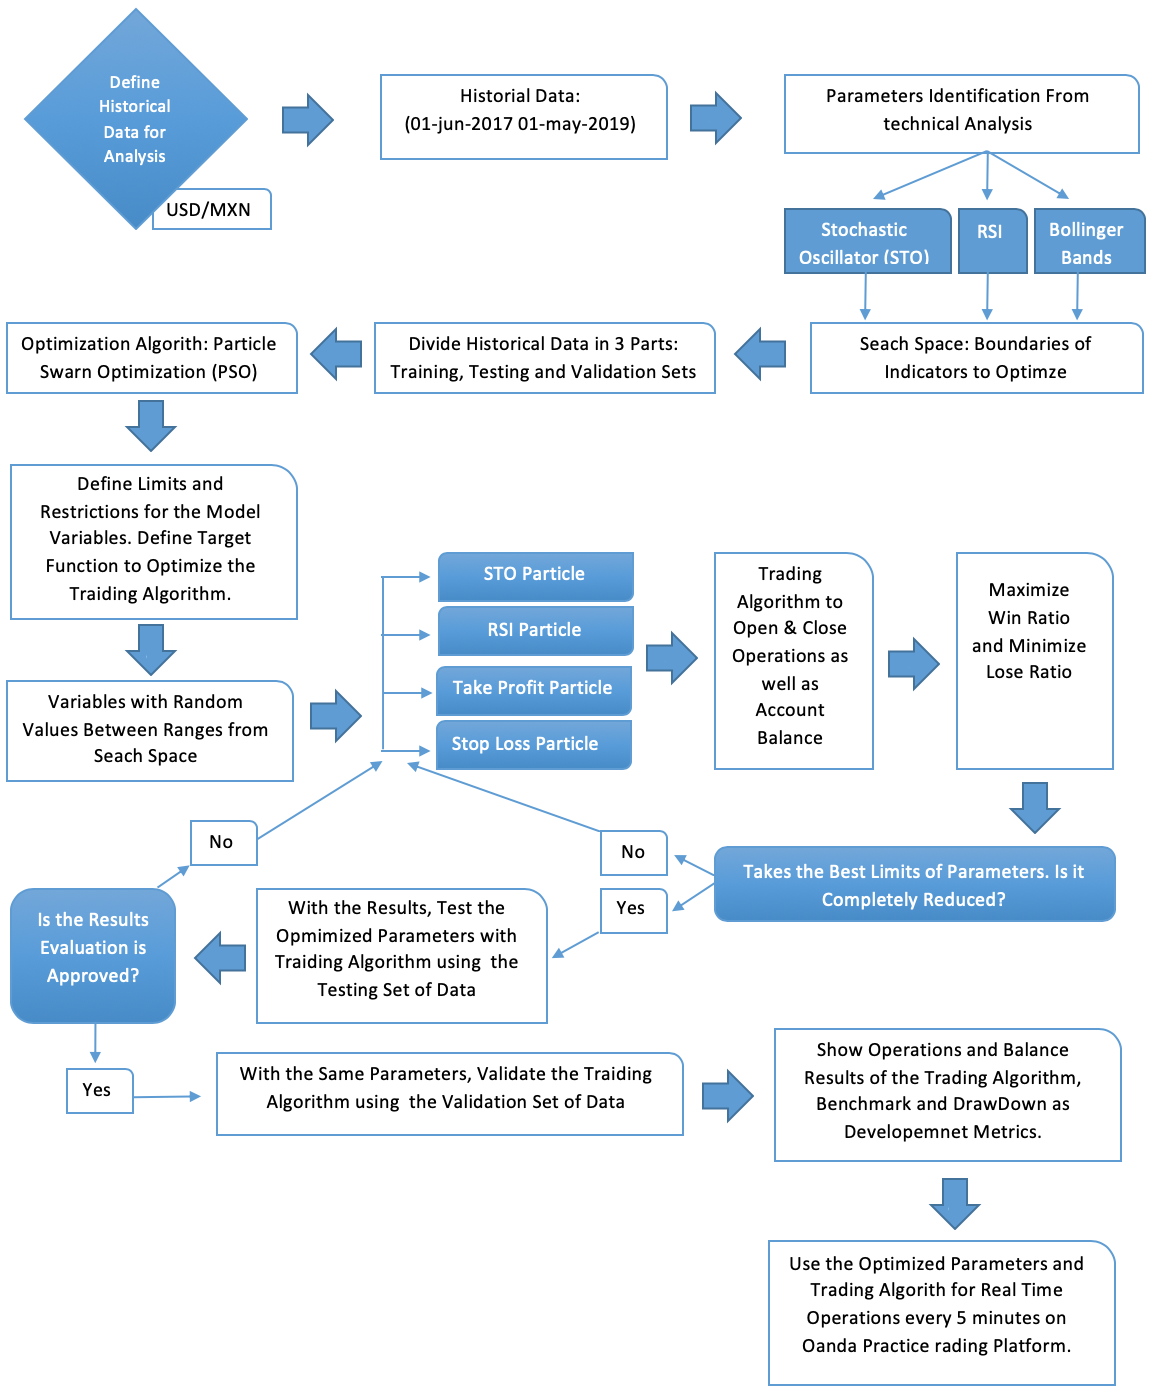

In [1]:
from IPython.display import Image
PATH = "/Users/pablomendoza/Documents/ITESO/Trading/Lab_1/ITESO/MYST_LABs/Final_Project/Notebook and Data/"
Image(filename = PATH + "Flowchart.png", width=450, height=750)

### B. Strategy Description
The main objective of the project is to develop a trading algorithm that works on real time with an API in OANDA practice platform. The currency chosen to be traded with this code is the USD/MXN. To develop, train, test and validate the trading algorithm, historical data from USD/MXN currency between the dates 01/June/2017 and 01/May/2019 with a granularity of 5 minutes is downloaded from OANDA. The decisions made by the trading algorithm are made with technical analysis (T.A.) indicators. Due to the general good reputation on financial literature, the T.A. indicators chossed to be part of the trading model are the Relative Strength Index (RSI), the Stochastic Oscillator (STO), and the Bollinger Bands (BB). The Search Space of these indicators according to general experience in the financial world are 30 and 70 for RSI, 20 and 80 for STO and BB created from 50 and 200 data before (Stockcharts, 2018). These recommended levels for TA indicators efficiency depends on plenty of variables, like volatility and granularity of time in data; therefore, to obtain optimized values for this trading algorithm the defined Search Sample for the model are 20-35 and 65-80 for RSI, 5-15 and 85-95 for STO, and 150 for BB. One of the first things to explain is the bias of these ranges to the outer boundaries of the indicators is that due to the granularity of the data the volatility tends to be higher.

To obtain a set of optimized T.A. parameters, the historical data is divided in 3 different sets, training, testing and validation data sets. With this Search Space for the T.A. parameters an optimization model is required to get the best ones in terms of profit ratio for the USD/MXN using a granularity of 5 minutes for the period time that goes from 01/June/2017 to 01/May/2019. The Particle Swarm Optimization (PSO) Model is used to improve the development of the trading algorithm. Using the training data set, the PSO model creates random values between the Search Space for the RSI and STO indicators (BB are not optimized) and use these values to open and close operations until the data is over. In algorithmic trading, the values of Take Profit (TP) and Stop Loss (SL) must be optimized too. According to finance literature recommendations TP range must be around 100 and 450 pips from spot, and SL range must be a half of TP range to improve earnings. The PSO creates random values in pips for TP and SL levels. To choose the best parameter, each iteration of the PSO model takes from the winning operations the most frequent ranges of TP and the least frequent ranges for SL and set these values as the new Search Space for TP and SL until the best parameters are reached. In the end, the PSO has the best TP level and therefor the best SL level. From the operations table, taking only the operations with earning, the most frequent values of RSI and STO are selected. If results are negative, PSO model must be used again until the parameters pass the testing section.

Once the best parameters are obtained, the trading code is evaluated using the tessting data set. If the results are positive in terms of Balance and DrawDown, the same parameters are used with the validation data set. Once the trading model, TP and SL levels and T.A. parameters for RSI and STO are set, the code is considered ready to be used in real time on OANDA practice platform.


### C. Mathemathical Principles
The mathemathical principles to calulate the T.A. indicators values and the way in which the Trading Model Works are shown below.

Assumptions of the Trading Model:
* There are no transaction fees of commission or spread types (though, they can be added easily).
* Operations are made instantly, therefore price is respected at the moment of the transaction.
* There is a finite amount of money to invest.
* Leverage is not considered in the project.

The RSI, is an T.A. indicator used to predict the tendency of prices identifying if the asset is overvalued and undervalued. The objctive of this indicator is to detect and predict a change in the tendency of an asset price.
$$RSI = {100}-\frac{100}{1+\frac{\sum{Growing Positve Rate}}{\sum{Growing Negative Rate}}}$$

The STO, is an T.A. indicator used to predict the tendency of prices identifying if the asset is overvalued and undervalued. The objctive of this indicator is to detect and predict a change in the tendency of an asset price.
$$STO = 100 \frac{C-L}{H-L} $$

Where:
* C – Last closing price
* L – Lower price from time window
* H – Higher price from time window

### Data Management
The currency chosen to be traded with this code is the USD/MXN. To develop, train, test and validate the trading algorithm, historical data from USD/MXN currency between the dates 01/June/2017 and 01/May/2019 with a granularity of 5 minutes is downloaded from OANDA. This implies that operations of opening and closing positions may be made every 5 minutes.

The next function downloads the mentioned data and save is as a csv file.

In [4]:
# -- Libraries Importation -- #
import random
import ta as ta
import numpy as np
%matplotlib inline
import pandas as pd
from datetime import date
from oandapyV20 import API
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import oandapyV20.endpoints.instruments as instruments
# -- Ignore warnings -- #
import warnings
warnings.filterwarnings("ignore")
# -- DataFrame Parameters -- #
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

In [5]:
# -- OANDA Parameters for Download-- #
A1_OA_Da = 16                     # Day Align
A1_OA_Ta = "America/Mexico_City"  # Time Align
A1_OA_Ai = "101-004-2221697-001"  # Id de cuenta
A1_OA_At = "practice"             # Tipo de cuenta
A1_OA_In = "USD_MXN"              # Instrumento
A1_OA_Gn = "M5"                   # Granularidad de velas (Minutes 5)
A1_OA_Ak = '4' + 'df969137c0bf800c5a04604c49450db-0e783d4124aa50b5736ebfe1a350eac' + '1'

# -- Data Range Function -- # 


def date_range(start_date_, end_date_, increment, period):
    """
    This function creates a list of the data range that will be imported
    :param start_date_: Start Date
    :param end_date_: End Date
    :param increment: number of increments
    :param period: type of increment (days, hours, minutes, etc)
    :return: list of the data range
    """
    result = []
    nxt = start_date_
    delta = relativedelta(**{period: increment})
    while nxt <= end_date_:
        result.append(nxt)
        nxt += delta
    return result



In [6]:
# # -- Download Initial Data -- #
# start_date = date(2017, 6, 1)  # Date for all transactions date(2017, 2, 16)
# end_date = date(2019, 5, 1)  # Date for all transactions date(2019, 3, 5)
# date_a = date_range(start_date, end_date, 1, 'days')
# list_a = []
# for n_date in range(len(date_a)-1):
#     F1 = date_a[n_date].strftime('%Y-%m-%dT%H:%M:%S')
#     F2 = date_a[n_date+1].strftime('%Y-%m-%dT%H:%M:%S')

#     # -- OANDA API Initialisation -- #
#     api = API(access_token=A1_OA_Ak)
#     # -- Historical DAta Download -- #
#     params = {"granularity": A1_OA_Gn, "price": "M", "dailyAlignment": A1_OA_Da,
#               "alignmentTimezone": A1_OA_Ta, "from": F1, "to": F2}
#     A1_Req1 = instruments.InstrumentsCandles(instrument=A1_OA_In, params=params)
#     A1_Hist = api.request(A1_Req1)
#     for i in range(len(A1_Hist['candles'])-1):
#             list_a.append({'TimeStamp': A1_Hist['candles'][i]['time'],
#                            'Open': A1_Hist['candles'][i]['mid']['o'],
#                            'High': A1_Hist['candles'][i]['mid']['h'],
#                            'Low': A1_Hist['candles'][i]['mid']['l'],
#                            'Close': A1_Hist['candles'][i]['mid']['c']})

# pd_hist = pd.DataFrame(list_a)  # Converts data to a DataFrame
# pd_hist = pd_hist[['TimeStamp', 'Open', 'High', 'Low', 'Close']]  # DF column names
# pd_hist['TimeStamp'] = pd.to_datetime(pd_hist['TimeStamp'])
# pd_hist['Open'] = pd.to_numeric(pd_hist['Open'])  # DF data to numeric
# pd_hist['High'] = pd.to_numeric(pd_hist['High'])  # DF data to numeric
# pd_hist['Low'] = pd.to_numeric(pd_hist['Low'])  # DF data to numeric
# pd_hist['Close'] = pd.to_numeric(pd_hist['Close'])  # DF data to numeric
# # -- Data Structure -- #
# df1_Prices = pd_hist  # Set DF name with shape (141828, 5)
# # df1_Prices.to_csv('01_Prices.csv')  
df1_Prices = pd.read_csv('/Users/pablomendoza/Documents/ITESO/Trading/Lab_1/ITESO/MYST_LABs/Final_Project/Notebook and Data/01_Prices.csv')



A small sample of the downloaded data is shown below, this data is just beginning of the Historical Data:

In [7]:
df1_Prices.head()

,Unnamed: 0,TimeStamp,Open,High,Low,Close
0,0,2017-06-01 04:00:00+00:00,18.63584,18.63589,18.63569,18.63575
1,1,2017-06-01 04:05:00+00:00,18.63574,18.64544,18.63382,18.63566
2,2,2017-06-01 04:10:00+00:00,18.63566,18.63582,18.63374,18.63392
3,3,2017-06-01 04:15:00+00:00,18.63390,18.63663,18.63216,18.63390
4,4,2017-06-01 04:20:00+00:00,18.63388,18.63416,18.63090,18.63299


A small sample of the downloaded data is shown below, this data is just ending of the Historical Data:

In [8]:
df1_Prices.tail()

,Unnamed: 0,TimeStamp,Open,High,Low,Close
141823,141823,2019-05-01 03:30:00+00:00,18.93537,18.93560,18.93520,18.93533
141824,141824,2019-05-01 03:35:00+00:00,18.93534,18.93542,18.93486,18.93489
141825,141825,2019-05-01 03:40:00+00:00,18.93488,18.93506,18.93452,18.93486
141826,141826,2019-05-01 03:45:00+00:00,18.93489,18.93506,18.93448,18.93474
141827,141827,2019-05-01 03:50:00+00:00,18.93473,18.93506,18.93471,18.93501


# 2. Optimization
### A. Parameters Identification
Due to the general good reputation on financial literature, the T.A. indicators chossed to be part of the trading model are the Relative Strength Index (RSI), the Stochastic Oscillator (STO), and the Bollinger Bands (BB).

The library of **ta**, helps to calculate the Bollinger Bands, RSI and the Stochastic Oscillator for a time series, based on its close price. 

In [9]:
# -- Technical Analysis Indicators Calculations -- #
# Technical analysis series with ta library
df1_Prices['BBH_Close'] = ta.bollinger_hband(df1_Prices['Close'], 150)
df1_Prices['BBL_Close'] = ta.bollinger_lband(df1_Prices['Close'], 150)
df1_Prices['RSI_Close'] = ta.rsi(df1_Prices['Close'], 51)
df1_Prices['STO_Close'] = ta.momentum.stoch(df1_Prices['High'], df1_Prices['Low'], 
                                            df1_Prices['Close'], 200, False)
df1_Prices.tail()


,Unnamed: 0,TimeStamp,Open,High,Low,Close,BBH_Close,BBL_Close,RSI_Close,STO_Close
141823,141823,2019-05-01 03:30:00+00:00,18.93537,18.93560,18.93520,18.93533,19.000847,18.904938,43.048894,9.378654
141824,141824,2019-05-01 03:35:00+00:00,18.93534,18.93542,18.93486,18.93489,18.998757,18.905802,42.403800,9.011191
141825,141825,2019-05-01 03:40:00+00:00,18.93488,18.93506,18.93452,18.93486,18.996499,18.906812,42.358790,8.986137
141826,141826,2019-05-01 03:45:00+00:00,18.93489,18.93506,18.93448,18.93474,18.994983,18.907306,42.172570,8.885919
141827,141827,2019-05-01 03:50:00+00:00,18.93473,18.93506,18.93471,18.93501,18.993443,18.907836,42.761396,9.111408


Once the T.A. calculation are made, the historical data set is divided in 3 different sets, training, testing and validation sets.

In [10]:
# -- Data Set Division -- #
df_Train = df1_Prices.iloc[0:5457]  # training set, from date(2017, 6, 1) to date(2017, 12, 31)
df_Test = df1_Prices.iloc[5457:60915]  # testing set, from date(2017, 6, 1) to date(2017, 12, 31)
df_Validate = df1_Prices.iloc[60915:]  # validation set, from date(2017, 6, 1) to date(2017, 12, 31)


Here are some Graphs to show the way the 3 indicators from T.A., behave during the observable time sample of the USD/MXN.\
For the project, the written functions on the next section, will Open positions depending of the values of each T.A. indicators.\
* Bollinger Bands activate when the spot cross the Bollinger Bands from bellow(High Band) and from above(Low Band).
* RSI_Param_UP = 75
* RSI_Param_DW = 25
* STO_Param_UP = 90
* STO_Param_DW = 10
\
For the project, the written functions on the next section, will Close positions depending of the values of TP and SL levels.\
* For opening operations, Take Profit (TP) level will be 200 pips from spot.
* For closing operations, Stop Loss (SL) level will be 100 pips from spot.
# TP and SL levels will be above or below spot depending if the position is Long or Short.

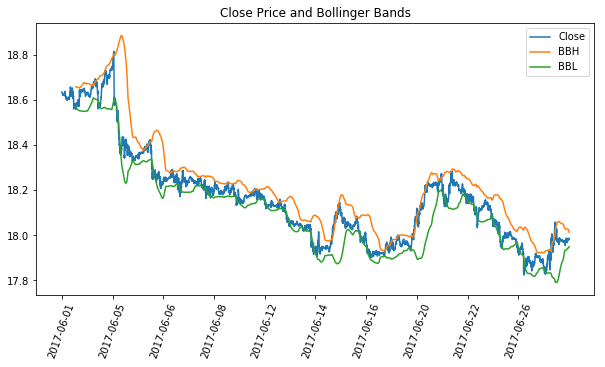

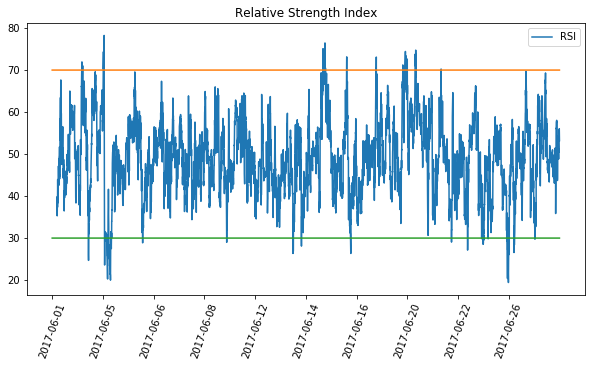

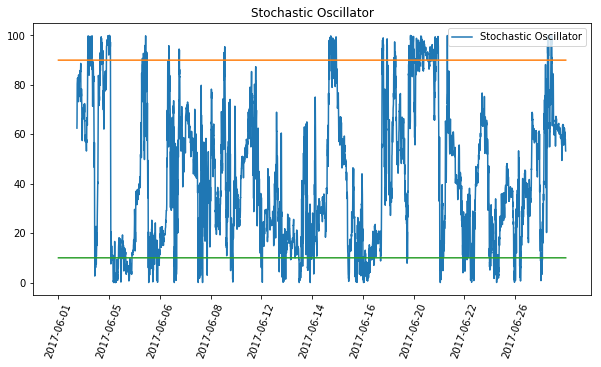

In [12]:
# -- Indicators Functions to Open and Close positions -- #
PIP_Conversion = 10000  # Relation between the currency with USD in pips
RSI_Param_UP = 70  # Upper RSI parameter for graph
RSI_Param_DW = 30  # Lower RSI parameter for graph
STO_Param_UP = 90  # Upper STO parameter for graph
STO_Param_DW = 10  # Lower STO parameter for graph
TP = 200/PIP_Conversion  # Conversion to pips for take profit
SL = 100/PIP_Conversion  # Conversion to pips for stop loss
Units = 1000  # Each operation unit

# -- Axes Legend -- #
n_tick = 10
list_a_ = [(np.floor(len(df_Train)/n_tick)), (np.floor(len(df_Train)/n_tick))]
list_b_ = [np.arange(n_tick)]
c = [a*b for a, b in zip(list_a_, list_b_)]
d = tuple([(str(df_Train['TimeStamp'][i])[0:10]) for i in c[0]])
# -- Bollinger Bands Graph -- #
plt.figure(1, figsize=(10, 5))
plt.title('Close Price and Bollinger Bands')
plt.plot(df_Train['Close'], label='Close')
plt.plot(df_Train['BBH_Close'], label='BBH')
plt.plot(df_Train['BBL_Close'], label='BBL')
plt.xticks(rotation=70)
plt.xticks(np.arange(0, len(df_Train), len(df_Train)/n_tick), d)
plt.legend()
plt.show()

# -- RSI Graph -- #
plt.figure(2, figsize=(10, 5))
plt.title('Relative Strength Index')
plt.plot(df_Train['RSI_Close'], label='RSI')
plt.plot(np.ones(len(df_Train))*RSI_Param_UP)
plt.plot(np.ones(len(df_Train))*RSI_Param_DW)
plt.xticks(rotation=70)
plt.xticks(np.arange(0, len(df_Train), len(df_Train)/n_tick), d)
plt.legend()
plt.show()

# -- Stochastic Oscilator Graph -- #
plt.figure(3, figsize=(10, 5))
plt.title('Stochastic Oscillator')
plt.plot(df_Train['STO_Close'], label='Stochastic Oscillator')
plt.plot(np.ones(len(df_Train))*STO_Param_UP)
plt.plot(np.ones(len(df_Train))*STO_Param_DW)
plt.xticks(rotation=70)
plt.xticks(np.arange(0, len(df_Train), len(df_Train)/n_tick), d)
plt.legend()
plt.show()


### B. Search Space
The Search Space of these indicators according to general experience in the financial world are 30 and 70 for RSI, 20 and 80 for STO and BB created from 50 and 200 data before (Stockcharts, 2018). These recommended levels for TA indicators efficiency depends on plenty of variables, like volatility and granularity of time in data; therefore, to obtain optimized values for this trading algorithm the defined Search Sample for the model are 20-35 and 65-80 for RSI, 5-15 and 85-95 for STO, and 150 for BB. One of the first things to explain is the bias of these ranges to the outer boundaries of the indicators is that due to the granularity of the data the volatility tends to be higher.

In [17]:
# -- Boundaries and Restrictions for Technical Analysis Indicators and Trading Algorithm Parameters Optimization
TP_UP_Limit = (460+1)/PIP_Conversion  # Conversion to pips for take profit
TP_DW_Limit = 100/PIP_Conversion  # Conversion to pips for take profit
SL_UP_Limit = TP_UP_Limit/2  # Conversion to pips for stop loss
SL_DW_Limit = (TP_DW_Limit/2)  # Conversion to pips for stop loss
RSI_Param_UP_1 = 65
RSI_Param_UP_2 = 80
RSI_Param_DW_1 = 20
RSI_Param_DW_2 = 35
STO_Param_UP_1 = 85
STO_Param_UP_2 = 95
STO_Param_DW_1 = 5
STO_Param_DW_2 = 15

### C. Method Decription
To obtain a set of optimized T.A. parameters, the historical data is divided in 3 different sets, training, testing and validation data sets. With this Search Space for the T.A. parameters an optimization model is required to get the best ones in terms of profit ratio for the USD/MXN using a granularity of 5 minutes for the period time that goes from 01/June/2017 to 01/May/2019. The Particle Swarm Optimization (PSO) Model is used to improve the development of the trading algorithm. Using the training data set, the PSO model creates random values between the Search Space for the RSI and STO indicators (BB are not optimized) and use these values to open and close operations until the data is over. In algorithmic trading, the values of Take Profit (TP) and Stop Loss (SL) must be optimized too. According to finance literature recommendations TP range must be around 100 and 450 pips from spot, and SL range must be a half of TP range to improve earnings. The PSO creates random values in pips for TP and SL levels. To choose the best parameter, each iteration of the PSO model takes from the winning operations the most frequent ranges of TP and the least frequent ranges for SL and set these values as the new Search Space for TP and SL until the best parameters are reached. In the end, the PSO has the best TP level and therefor the best SL level. From the operations table, taking only the operations with earning, the most frequent values of RSI and STO are selected.

<Figure size 432x288 with 0 Axes>

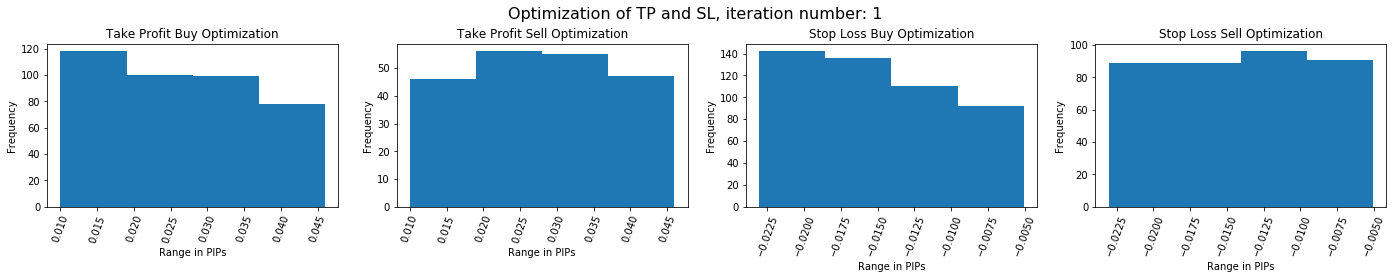

<Figure size 432x288 with 0 Axes>

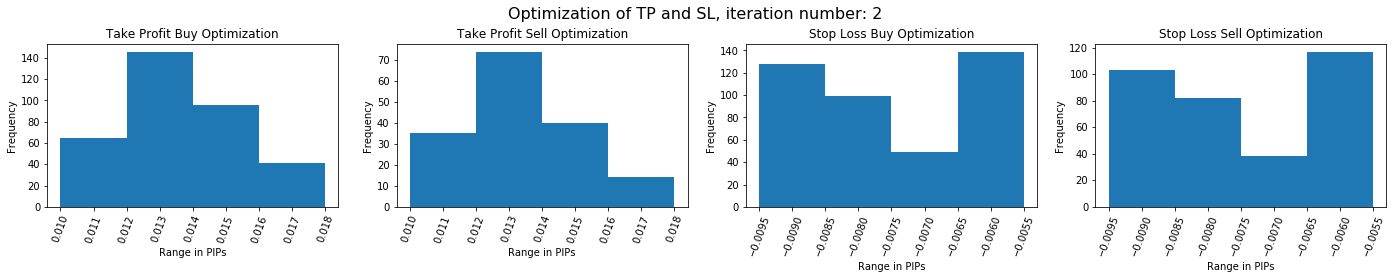

<Figure size 432x288 with 0 Axes>

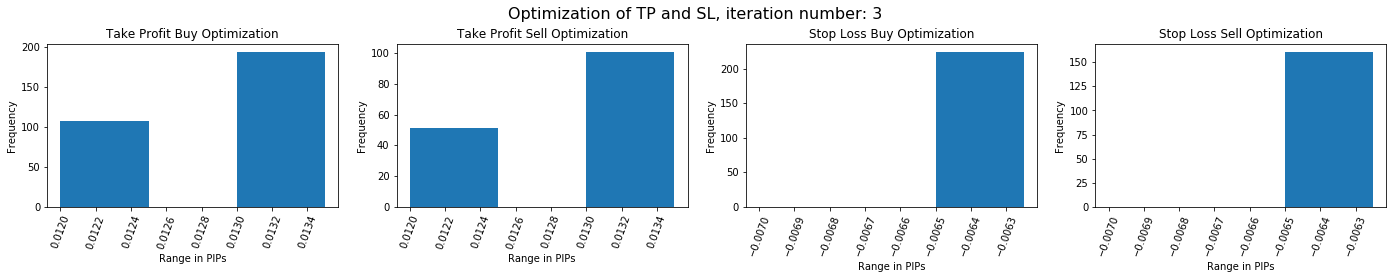

The Optimum Value for TP in pips is:
135.0
The Optimum Value for TP in pips is:
67.5


<Figure size 432x288 with 0 Axes>

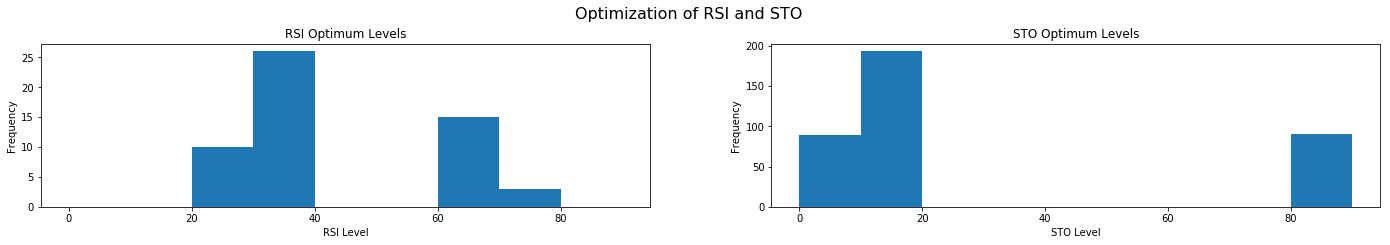

RSI value must be between this 40 and 30
RSI value must be between this 70 and 60
STO value must be between this 20 and 10
STO value must be between this 90 and 80


In [18]:
# # -- Boundaries and Restrictions for Technical Analysis Indicators and Trading Algorithm Parameters Optimization
# TP_UP_Limit = (460+1)/PIP_Conversion  # Conversion to pips for take profit
# TP_DW_Limit = 100/PIP_Conversion  # Conversion to pips for take profit
# SL_UP_Limit = TP_UP_Limit/2  # Conversion to pips for stop loss
# SL_DW_Limit = (TP_DW_Limit/2)  # Conversion to pips for stop loss
# RSI_Param_UP_1 = 65
# RSI_Param_UP_2 = 80
# RSI_Param_DW_1 = 20
# RSI_Param_DW_2 = 35
# STO_Param_UP_1 = 85
# STO_Param_UP_2 = 95
# STO_Param_DW_1 = 5
# STO_Param_DW_2 = 15
# df_Train = df1_Prices.iloc[0:5000]  # Delete this line at the end
# -- Optimization of Parameters -- #
Cap_In = 100000
Pip_c = PIP_Conversion
Max_line_b = list()
Min_line_s = list()
Max_line_s = list()
Min_line_b = list()
Hist_bins = [.009, .002, .0005]
for iter in range(len(Hist_bins)):
    df2_Ops = pd.DataFrame(columns=['Folio', 'Ini_Date', 'End_Date', 'Op_Type', 'Comment', 'Comment Val', 'Units',
                           'Spot', 'TP', 'SL', 'Close_P', 'Close_Reason', 'Status', 'Margin'])
    for k in range(len(df_Train)):
        # -- Particles for the Model -- #
        TP_particle = round(random.uniform(TP_DW_Limit, TP_UP_Limit), 3)  # Take Profit particle for PSO
        SL_particle = TP_particle/2
        RSI_UP_particle = random.randrange(RSI_Param_UP_1, RSI_Param_UP_2, 1)  # RSI Upper Level particle for PSO
        RSI_DW_particle = 100-RSI_UP_particle  # RSI Lower Level particle for PSO
        STO_UP_particle = random.randrange(STO_Param_UP_1, STO_Param_UP_2, 1)  # STO Upper Level particle for PSO
        STO_DW_particle = 100-STO_UP_particle  # STO Lower Level particle for PSO
        # -- Trading Optimization Function with Operation Open and Close Algorithm -- #
        # This part open orders depending on RSI, STO and Bollinger bands parameters
        # -- Add Operation -- #
        # Open operation due to RSI upper level
        if df_Train['RSI_Close'][k] >= RSI_UP_particle:
            df2_Ops.loc[-1] = ['Folio', str(df_Train['TimeStamp'][k])[0:16], '-', 'Sell', 'RSI', 
                               RSI_UP_particle, Units, df_Train['Close'][k], 
                               df_Train['Close'][k] - TP_particle, 
                               df_Train['Close'][k] + SL_particle, '-', '-', 'Open', '-']
            df2_Ops.index = df2_Ops.index + 1
        # Open operation due to RSI lower level
        elif df_Train['RSI_Close'][k] <= RSI_DW_particle:
            df2_Ops.loc[-1] = ['Folio', str(df_Train['TimeStamp'][k])[0:16], '-', 'Buy', 'RSI', 
                               RSI_DW_particle, Units, df_Train['Close'][k], 
                               df_Train['Close'][k] + TP_particle, 
                               df_Train['Close'][k] - SL_particle, '-', '-', 'Open', '-']
            df2_Ops.index = df2_Ops.index + 1   
        # Open operation due to STO upper level
        elif df_Train['STO_Close'][k] >= STO_UP_particle:
            df2_Ops.loc[-1] = ['Folio', str(df_Train['TimeStamp'][k])[0:16], '-', 'Sell', 'STO', 
                               STO_UP_particle, Units, df_Train['Close'][k], 
                               df_Train['Close'][k] - TP_particle, 
                               df_Train['Close'][k] + SL_particle, '-', '-', 'Open', '-']
            df2_Ops.index = df2_Ops.index + 1
        # Open operation due to STO lower level
        elif df_Train['STO_Close'][k] <= STO_DW_particle:
            df2_Ops.loc[-1] = ['Folio', str(df_Train['TimeStamp'][k])[0:16], '-', 'Buy', 'STO', 
                               STO_DW_particle, Units, df_Train['Close'][k], 
                               df_Train['Close'][k] + TP_particle, 
                               df_Train['Close'][k] - SL_particle, '-', '-', 'Open', '-']
            df2_Ops.index = df2_Ops.index + 1  
        # Open operation due to Lower Bollinger Band
        elif df_Train['BBL_Close'][k] >= df_Train['Close'][k]:
            df2_Ops.loc[-1] = ['Folio', str(df_Train['TimeStamp'][k])[0:16], '-', 'Buy', 'BBL', 
                               0, Units, df_Train['Close'][k], df_Train['Close'][k] + TP_particle, 
                               df_Train['Close'][k] - SL_particle, '-', '-', 'Open', '-']
            df2_Ops.index = df2_Ops.index + 1     
        # Open operation due to Upper Bollinger Band
        elif df_Train['BBH_Close'][k] <= df_Train['Close'][k]:
            df2_Ops.loc[-1] = ['Folio', str(df_Train['TimeStamp'][k])[0:16], '-', 'Sell', 'BBH', 
                               0, Units, df_Train['Close'][k], df_Train['Close'][k] - TP_particle, 
                               df_Train['Close'][k] + SL_particle, '-', '-', 'Open', '-']
            df2_Ops.index = df2_Ops.index + 1
        else:
            pass       
        # -- Check and Close Op -- #
        # This code check all open operations and verify if one or some of them
        # have a signal to close it, take profit or stop loss
        df_Temp = df2_Ops[df2_Ops['Status'] == 'Open']
        for n_2 in df_Temp.index:
            # Close buy operation due to take profit
            if df_Temp['Op_Type'][n_2] == 'Buy' and df_Temp['TP'][n_2] <= df_Train['Close'][k]:
                df2_Ops['Status'][n_2] = 'Closed'
                df2_Ops['End_Date'][n_2] = df_Train['TimeStamp'][k]
                df2_Ops['Margin'][n_2] = df_Train['Close'][k] - df2_Ops['Spot'][n_2]
                df2_Ops['Close_P'][n_2] = df_Train['Close'][k]
                df2_Ops['Close_Reason'][n_2] = 'TP'
            # Close buy operation due to stop loss
            elif df_Temp['Op_Type'][n_2] == 'Buy' and df_Temp['SL'][n_2] >= df_Train['Close'][k]:
                df2_Ops['Status'][n_2] = 'Closed'
                df2_Ops['End_Date'][n_2] = df_Train['TimeStamp'][k]
                df2_Ops['Margin'][n_2] = df_Train['Close'][k] - df2_Ops['Spot'][n_2]
                df2_Ops['Close_P'][n_2] = df_Train['Close'][k]
                df2_Ops['Close_Reason'][n_2] = 'SL'
            # Close sell operation due to take profit
            elif df_Temp['Op_Type'][n_2] == 'Sell' and df_Temp['TP'][n_2] >= df_Train['Close'][k]: 
                df2_Ops['Status'][n_2] = 'Closed'
                df2_Ops['End_Date'][n_2] = df_Train['TimeStamp'][k]
                df2_Ops['Margin'][n_2] = df2_Ops['Spot'][n_2] - df_Train['Close'][k]
                df2_Ops['Close_P'][n_2] = df_Train['Close'][k]
                df2_Ops['Close_Reason'][n_2] = 'TP'
            # Close sell operation due to stop loss
            elif df_Temp['Op_Type'][n_2] == 'Sell' and df_Temp['SL'][n_2] <= df_Train['Close'][k]:
                df2_Ops['Status'][n_2] = 'Closed'
                df2_Ops['End_Date'][n_2] = df_Train['TimeStamp'][k]
                df2_Ops['Margin'][n_2] = df2_Ops['Spot'][n_2] - df_Train['Close'][k]
                df2_Ops['Close_P'][n_2] = df_Train['Close'][k]
                df2_Ops['Close_Reason'][n_2] = 'SL'
            else:
                pass
    # -- Choosing the Best Parameters with the PSO -- #
    Closed_df = df2_Ops[df2_Ops['Status'] == 'Closed']
    # DataFrames by Reasons of Closing
    Reason_TP_BUY_df = Closed_df[(Closed_df['Close_Reason'] == 'TP') & (Closed_df['Op_Type'] == 'Buy')]
    Reason_TP_SELL_df = Closed_df[(Closed_df['Close_Reason'] == 'TP') & (Closed_df['Op_Type'] == 'Sell')]
    Reason_SL_BUY_df = Closed_df[(Closed_df['Close_Reason'] == 'SL') & (Closed_df['Op_Type'] == 'Buy')]
    Reason_SL_SELL_df = Closed_df[(Closed_df['Close_Reason'] == 'SL') & (Closed_df['Op_Type'] == 'Sell')]
    # Outcomes to Optimize
    Margin_TP_BUY = -(Reason_TP_BUY_df['Spot'] - Reason_TP_BUY_df['TP'])
    Margin_TP_SELL = (Reason_TP_SELL_df['Spot'] - Reason_TP_SELL_df['TP'])
    Margin_SL_BUY = -(Reason_SL_BUY_df['Spot'] - Reason_SL_BUY_df['SL'])
    Margin_SL_SELL = (Reason_SL_SELL_df['Spot'] - Reason_SL_SELL_df['SL'])
    # Frequency and Success of Decisions
    # Take Profit Buy Optimization
    plt.figure(iter)
    plt.figure(figsize=(24, 3))
    ttl = plt.suptitle('Optimization of TP and SL, iteration number: ' + str(iter+1), fontsize=16)
    ttl.set_position([.5, 1.05])
    plt.subplot(141)
    Fr_TP_BUY = plt.hist(list(Margin_TP_BUY), bins=np.arange(TP_DW_Limit, 
                                                             TP_UP_Limit, 
                                                             Hist_bins[iter]))
    plt.title('Take Profit Buy Optimization')
    plt.xlabel('Range in PIPs')
    plt.ylabel('Frequency')
    plt.xticks(rotation=70)
    # Take Profit Sell Optimization
    plt.subplot(142)
    Fr_TP_SELL = plt.hist(list(Margin_TP_SELL), bins=np.arange(TP_DW_Limit,
                                                               TP_UP_Limit,
                                                               Hist_bins[iter]))
    plt.title('Take Profit Sell Optimization')
    plt.xlabel('Range in PIPs')
    plt.ylabel('Frequency')
    plt.xticks(rotation=70)
    # Stop Loss Buy Optimization
    plt.subplot(143)
    Fr_SL_BUY = plt.hist(list(Margin_SL_BUY), bins=np.arange(-SL_UP_Limit,
                                                             -SL_DW_Limit,
                                                             Hist_bins[iter]/2))
    plt.title('Stop Loss Buy Optimization')
    plt.xlabel('Range in PIPs')
    plt.ylabel('Frequency')
    plt.xticks(rotation=70)
    # Stop Loss Sell Optimization
    plt.subplot(144)
    Fr_SL_SELL = plt.hist(list(Margin_SL_SELL), bins=np.arange(-SL_UP_Limit,
                                                               -SL_DW_Limit,
                                                               Hist_bins[iter]/2))
    plt.title('Stop Loss Sell Optimization')
    plt.xlabel('Range in PIPs')
    plt.ylabel('Frequency')
    plt.xticks(rotation=70)
    plt.show()
    # Best From Outcomes
    (m_1, w_1) = min((v_1, w_1) for w_1, v_1 in enumerate(Fr_SL_BUY[0]))  # (Value, Position)
    (m_2, w_2) = min((v_2, w_2) for w_2, v_2 in enumerate(Fr_SL_SELL[0]))  # (Value, Position)
    (m_3, w_3) = max((v_3, w_3) for w_3, v_3 in enumerate(Fr_TP_BUY[0]))  # (Value, Position)
    (m_4, w_4) = max((v_4, w_4) for w_4, v_4 in enumerate(Fr_TP_SELL[0]))  # (Value, Position)
    Min_line_b.append(m_1/Fr_SL_BUY[0].sum())
    Min_line_s.append(m_2/Fr_SL_SELL[0].sum())
    Max_line_b.append(m_3/Fr_TP_BUY[0].sum())
    Max_line_s.append(m_4/Fr_TP_SELL[0].sum())
    # Generation Optimum Values for the Model
    Val_SL_BUY = (Fr_SL_BUY[1][w_1] + Fr_SL_BUY[1][w_1+1])/2
    Val_SL_SELL = (Fr_SL_SELL[1][w_1] + Fr_SL_SELL[1][w_1+1])/2
    Val_TP_BUY = (Fr_TP_BUY[1][w_1] + Fr_TP_BUY[1][w_1+1])/2
    Val_TP_SELL = (Fr_TP_SELL[1][w_1] + Fr_TP_SELL[1][w_1+1])/2
    # Optimum Ranges
    TP_UP_Limit = Fr_TP_BUY[1][w_3+1]   # Conversion to pips for take profit
    TP_DW_Limit = Fr_TP_BUY[1][w_3]     # Conversion to pips for take profit
    SL_UP_Limit = TP_UP_Limit/2  # Conversion to pips for stop loss
    SL_DW_Limit = TP_DW_Limit/2  # Conversion to pips for stop loss
print('The Optimum Value for TP in pips is:')
print(np.floor(PIP_Conversion*TP_UP_Limit))
print('The Optimum Value for TP in pips is:')
print((np.floor(PIP_Conversion*TP_UP_Limit))/2)
Closed_df = df2_Ops[df2_Ops['Status'] == 'Closed']
RSI_Res = Closed_df[(Closed_df['Close_Reason'] == 'TP') & (Closed_df['Comment'] == 'RSI')]
STO_Res = Closed_df[(Closed_df['Close_Reason'] == 'TP') & (Closed_df['Comment'] == 'STO')]
Values_RSI = RSI_Res['Comment Val']
Values_STO = STO_Res['Comment Val']
# Histograms RSI and STO
plt.figure(4)
plt.figure(figsize=(24, 3))
ttl = plt.suptitle('Optimization of RSI and STO', fontsize=16)
ttl.set_position([.5, 1.05])
plt.subplot(121)
Fr_RSI = plt.hist(list(Values_RSI), bins=np.arange(0, 100, 10))
plt.title('RSI Optimum Levels')
plt.xlabel('RSI Level')
plt.ylabel('Frequency')
plt.subplot(122)
Fr_STO = plt.hist(list(Values_STO), bins=np.arange(0, 100, 10))
plt.title('STO Optimum Levels')
plt.xlabel('STO Level')
plt.ylabel('Frequency')
plt.show()
(m_5, w_5) = max((v_5, w_5) for w_5, v_5 in enumerate(Fr_RSI[0]))  # (Value, Position)
if w_5 <= 5:
    print('RSI value must be between this ' + str(10*(w_5+1)) + ' and ' + str(10*w_5))
    print('RSI value must be between this ' + str(100 - 10*w_5) + ' and ' + str(100 - 10*(w_5+1)))
else:
    print('RSI value must be between this ' + str(10*w_5) + ' and ' + str(10*(w_5+1)))
    print('RSI value must be between this ' + str(100 - 10*(w_5+1)) + ' and ' + str(100 - 10*w_5))
(m_6, w_6) = max((v_6, w_6) for w_6, v_6 in enumerate(Fr_STO[0]))  # (Value, Position)
if w_6 <= 5:
    print('STO value must be between this ' + str(10*(w_6+1)) + ' and ' + str(10*w_6))
    print('STO value must be between this ' + str(100 - 10*w_6) + ' and ' + str(100 - 10*(w_6+1)))
else:
    print('STO value must be between this ' + str(10*w_6) + ' and ' + str(10*(w_6+1)))
    print('STO value must be between this ' + str(100 - 10*(w_6+1)) + ' and ' + str(100 - 10*w_6))


PSO converge to optimum values for TP and SL is show below:

<Figure size 432x288 with 0 Axes>

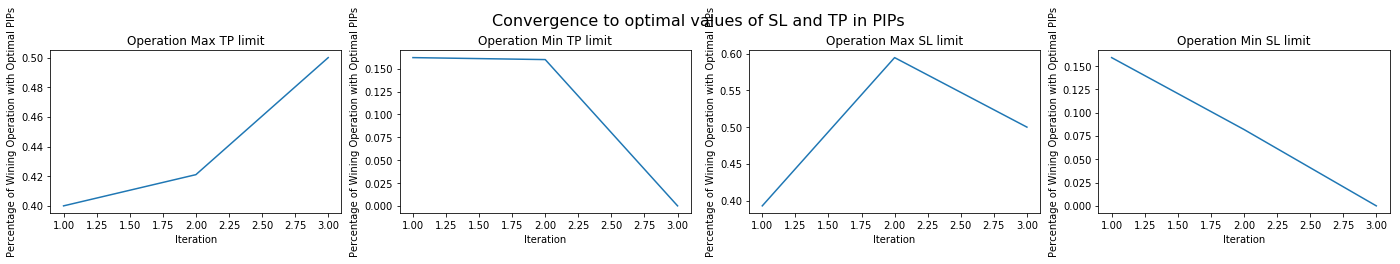

In [ ]:
plt.figure(4)
plt.figure(figsize=(24, 3))
ttl = plt.suptitle('Convergence to optimal values of SL and TP in PIPs', fontsize=16)
ttl.set_position([.5, 1.05])
plt.subplot(141)
plt.plot(list([1, 2, 3]), Max_line_b)
plt.title('Operation Max TP limit')
plt.ylabel('Percentage of Wining Operation with Optimal PIPs')
plt.xlabel('Iteration')
plt.subplot(142)
plt.plot(list([1, 2, 3]), Min_line_b)
plt.title('Operation Min TP limit')
plt.ylabel('Percentage of Wining Operation with Optimal PIPs')
plt.xlabel('Iteration')
plt.subplot(143)
plt.plot(list([1, 2, 3]), Max_line_s)
plt.title('Operation Max SL limit')
plt.ylabel('Percentage of Wining Operation with Optimal PIPs')
plt.xlabel('Iteration')
plt.subplot(144)
plt.plot(list([1, 2, 3]), Min_line_s)
plt.title('Operation Min SL limit')
plt.ylabel('Percentage of Wining Operation with Optimal PIPs')
plt.xlabel('Iteration')
plt.show()


In [ ]:
print('a')

This part of the code manage the opening and closing of positions thought out the period of time of the historical data with the parameters mentioned above. The expected result is a DataFrame with all the transactions made, including the closed and open positions, and another DataFrame with the account balance through time. 

In [105]:
# -- Testing -- #







## Copia
# -- Optimization of Parameters -- #
Rend_Df = pd.DataFrame()
name = list()


# -- Particles for the Model -- #
TP_particle = random.randrange(TP_DW_Limit, TP_UP_Limit, 0.001)  # Take Profit particle for PSO
SL_particle = random.randrange(SL_DW_Limit, SL_UP_Limit, 0.001)  # Stop Loss particle for PSO
RSI_UP_particle = random.randrange(RSI_Param_UP_1, RSI_Param_UP_2, 1)  # RSI Upper Level particle for PSO
RSI_DW_particle = random.randrange(RSI_Param_DW_1, RSI_Param_DW_2, 1)  # RSI Lower Level particle for PSO
STO_UP_particle = random.randrange(STO_Param_UP_1, STO_Param_UP_2, 1)  # STO Upper Level particle for PSO
STO_DW_particle = random.randrange(STO_Param_DW_1, STO_Param_DW_2, 1)  # STO Lower Level particle for PSO





# lists of parameters for RSI and STO to optimize


for k in range(len(RSI_Param_DW_)):
    for m in range(len(STO_Param_DW_)):
        
        
        
        
        RSI_Param_UP = RSI_Param_UP_[k]
        RSI_Param_DW = RSI_Param_DW_[k]
        STO_Param_UP = STO_Param_UP_[m]
        STO_Param_DW = STO_Param_DW_[m]
        Cap_In = 100000    
        
        df2_Ops = pd.DataFrame(columns=['Folio', 'Ini_Date', 'End_Date', 'Op_Type', 'Comment',
                                        'Units', 'Spot', 'TP', 'SL', 'Close_P', 'Close_Reason', 
                                        'Status', 'Margin'])
        # -- Op Open and Close Algorithm -- #
        # This part open orders depending on RSI, STO 
        # and Bollinger bands parameters
        for n_ in range(len(df1_Prices)):
            # -- Add Operation -- #
            # Open operation due to RSI upper level
            if df1_Prices['RSI_Close'][n_] >= RSI_Param_UP:
                df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Sell', 'RSI', 
                                   Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] - TP, 
                                   df1_Prices['Close'][n_] + SL, '-', '-', 'Open', '-']
                df2_Ops.index = df2_Ops.index + 1
            # Open operation due to RSI lower level
            elif df1_Prices['RSI_Close'][n_] <= RSI_Param_DW:
                df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Buy', 'RSI', 
                                   Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] + TP, 
                                   df1_Prices['Close'][n_] - SL, '-', '-', 'Open', '-']
                df2_Ops.index = df2_Ops.index + 1   
            # Open operation due to STO upper level
            elif df1_Prices['STO_Close'][n_] >= STO_Param_UP:
                df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Sell', 'STO', 
                                   Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] - TP, 
                                   df1_Prices['Close'][n_] + SL, '-', '-', 'Open', '-']
                df2_Ops.index = df2_Ops.index + 1
            # Open operation due to STO lower level
            elif df1_Prices['STO_Close'][n_] <= STO_Param_DW:
                df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Buy', 'STO', 
                                   Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] + TP, 
                                   df1_Prices['Close'][n_] - SL, '-', '-', 'Open', '-']
                df2_Ops.index = df2_Ops.index + 1  
            # Open operation due to Lower Bollinger Band
            elif df1_Prices['BBL_Close'][n_] >= df1_Prices['Close'][n_]:
                df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Buy', 'BBL', 
                                   Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] + TP, 
                                   df1_Prices['Close'][n_] - SL, '-', '-', 'Open', '-']
                df2_Ops.index = df2_Ops.index + 1     
            # Open operation due to Upper Bollinger Band
            elif df1_Prices['BBH_Close'][n_] <= df1_Prices['Close'][n_]:
                df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Sell', 'BBH', 
                                   Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] - TP, 
                                   df1_Prices['Close'][n_] + SL, '-', '-', 'Open', '-']
                df2_Ops.index = df2_Ops.index + 1
            else:
                pass
            # -- Check and Close Op -- #
            # This code check all open operations and verify if one or some of them
            # have a signal to close it, take profit or stop loss
            df_Temp = df2_Ops[df2_Ops['Status'] == 'Open']
            for n_2 in df_Temp.index:
                # Close buy operation due to take profit
                if df_Temp['Op_Type'][n_2] == 'Buy' and df_Temp['TP'][n_2] <= df1_Prices['Close'][n_]:
                    df2_Ops['Status'][n_2] = 'Closed'
                    df2_Ops['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
                    df2_Ops['Margin'][n_2] = df1_Prices['Close'][n_] - df2_Ops['Spot'][n_2]
                    df2_Ops['Close_P'][n_2] = df1_Prices['Close'][n_]
                    df2_Ops['Close_Reason'][n_2] = 'TP'
                # Close buy operation due to stop loss
                elif df_Temp['Op_Type'][n_2] == 'Buy' and df_Temp['SL'][n_2] >= df1_Prices['Close'][n_]:
                    df2_Ops['Status'][n_2] = 'Closed'
                    df2_Ops['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
                    df2_Ops['Margin'][n_2] = df1_Prices['Close'][n_] - df2_Ops['Spot'][n_2]
                    df2_Ops['Close_P'][n_2] = df1_Prices['Close'][n_]
                    df2_Ops['Close_Reason'][n_2] = 'SL'
                # Close sell operation due to take profit
                elif df_Temp['Op_Type'][n_2] == 'Sell' and df_Temp['TP'][n_2] >= df1_Prices['Close'][n_]: 
                    df2_Ops['Status'][n_2] = 'Closed'
                    df2_Ops['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
                    df2_Ops['Margin'][n_2] = df2_Ops['Spot'][n_2] - df1_Prices['Close'][n_]
                    df2_Ops['Close_P'][n_2] = df1_Prices['Close'][n_]
                    df2_Ops['Close_Reason'][n_2] = 'TP'
                # Close sell operation due to stop loss
                elif df_Temp['Op_Type'][n_2] == 'Sell' and df_Temp['SL'][n_2] <= df1_Prices['Close'][n_]:
                    df2_Ops['Status'][n_2] = 'Closed'
                    df2_Ops['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
                    df2_Ops['Margin'][n_2] = df2_Ops['Spot'][n_2] - df1_Prices['Close'][n_]
                    df2_Ops['Close_P'][n_2] = df1_Prices['Close'][n_]
                    df2_Ops['Close_Reason'][n_2] = 'SL'
                else:
                    pass
        # Save T.A. parameters on list for each combination and save it
        name.append(str(k) + '_' + str(k) + '_' + str(m) + '_' + str(m)) 
        df2_Ops = df2_Ops[df2_Ops['Status'] == 'Closed']
        Rends = df2_Ops['Margin']*df2_Ops['Units']
        Rends_Acu = Rends.cumsum() * Cap_In/100
        Rend_Df = Rend_Df.append(Rends_Acu, 1) # add list to a DF to chose the best
        
        
        
        
        
Rend_Df = Rend_Df.T
Rend_Df.columns = name  # The name of each column represents the index of the parameters
max_row = list(Rend_Df.iloc[0, :])
max_id = max_row.index(max(max_row))  # selection of the best parameter
max_name = Rend_Df.columns[max_id]
max_split = max_name.split('_')  # ['3', '3', '6', '6']
print('The best parameters are:')
print('RSI_Param_UP: ' + str(RSI_Param_UP_[int(max_split[0])]))
print('RSI_Param_DW: ' + str(RSI_Param_DW_[int(max_split[1])]))
print('STO_Param_UP: ' + str(STO_Param_UP_[int(max_split[2])]))
print('STO_Param_DW: ' + str(STO_Param_DW_[int(max_split[3])]))


ValueError: non-integer arg 1 for randrange()

With the best parameters for the technical analysis indicators, the same code will simulate transactions and balance for all data. Results wll be shown below. A initial capital of 100,000.00 is setup.

In [12]:
# -- Parameters -- #
# Selection the optimum parameters from above
RSI_Param_UP = 71 #RSI_Param_UP_[int(max_split[0])]
RSI_Param_DW = 29 #RSI_Param_DW_[int(max_split[1])]
STO_Param_UP = 93 #STO_Param_UP_[int(max_split[2])]
STO_Param_DW = 7 # STO_Param_DW_[int(max_split[3])]
df1_Prices = pd.read_csv('Data_Set_Technical_Analysis.csv')  # all data with size (151536, 6)
# df1_Prices = df1_Prices.iloc[:350, :]  # For sampling Data from the Data Set
Cap_In = 100000  
# -- Technical Analysis Indicators Calculations -- #
# T.A. indicators for all data. 
df1_Prices['BBH_Close'] = ta.bollinger_hband(df1_Prices['Close'], 150)
df1_Prices['BBL_Close'] = ta.bollinger_lband(df1_Prices['Close'], 150)
df1_Prices['RSI_Close'] = ta.rsi(df1_Prices['Close'], 51)
df1_Prices['STO_Close'] = ta.momentum.stoch(df1_Prices['High'], df1_Prices['Low'], 
                                            df1_Prices['Close'], 200, False)
# -- Operations and Balance -- #
df2_Ops = pd.DataFrame(columns=['Folio', 'Ini_Date', 'End_Date', 'Op_Type', 'Comment',
                                'Units', 'Spot', 'TP', 'SL', 'Close_P', 'Close_Reason', 
                                'Status', 'Margin'])
df3_Acc = pd.DataFrame(columns=['Date', 'Cash', 'Float', 'Balance', 'Yield_Balance_Acu %',
                                'Comment', 'Earn/Loss'])
df3_Acc.loc[-1] = [str(df1_Prices['TimeStamp'][0])[0:16], Cap_In, 0, Cap_In + 0,
                   (((Cap_In + 0)/Cap_In)-1)*100, '-', (Cap_In + 0)-Cap_In]
# -- Op Open and Close Algorithm -- #
for n_ in range(len(df1_Prices)):
    # -- Add Operation -- #
    if df1_Prices['RSI_Close'][n_] >= RSI_Param_UP:
        df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Sell', 'RSI', 
                           Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] - TP, 
                           df1_Prices['Close'][n_] + SL, '-', '-', 'Open', '-']
        df2_Ops.index = df2_Ops.index + 1
    elif df1_Prices['RSI_Close'][n_] <= RSI_Param_DW:
        df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Buy', 'RSI', 
                           Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] + TP, 
                           df1_Prices['Close'][n_] - SL, '-', '-', 'Open', '-']
        df2_Ops.index = df2_Ops.index + 1   
    elif df1_Prices['STO_Close'][n_] >= STO_Param_UP:
        df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Sell', 'STO', 
                           Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] - TP, 
                           df1_Prices['Close'][n_] + SL, '-', '-', 'Open', '-']
        df2_Ops.index = df2_Ops.index + 1
    elif df1_Prices['STO_Close'][n_] <= STO_Param_DW:
        df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Buy', 'STO', 
                           Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] + TP, 
                           df1_Prices['Close'][n_] - SL, '-', '-', 'Open', '-']
        df2_Ops.index = df2_Ops.index + 1  
    elif df1_Prices['BBL_Close'][n_] >= df1_Prices['Close'][n_]:
        df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Buy', 'BBL', 
                           Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] + TP, 
                           df1_Prices['Close'][n_] - SL, '-', '-', 'Open', '-']
        df2_Ops.index = df2_Ops.index + 1     
    elif df1_Prices['BBH_Close'][n_] <= df1_Prices['Close'][n_]:
        df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Sell', 'BBH', 
                           Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] - TP, 
                           df1_Prices['Close'][n_] + SL, '-', '-', 'Open', '-']
        df2_Ops.index = df2_Ops.index + 1
    else:
        pass
    # -- Check and Close Op -- #
    df_Temp = df2_Ops[df2_Ops['Status'] == 'Open']
    for n_2 in df_Temp.index:
        if df_Temp['Op_Type'][n_2] == 'Buy' and df_Temp['TP'][n_2] <= df1_Prices['Close'][n_]:
            df2_Ops['Status'][n_2] = 'Closed'
            df2_Ops['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
            df2_Ops['Margin'][n_2] = float(df1_Prices['Close'][n_] - df2_Ops['Spot'][n_2])
            df2_Ops['Close_P'][n_2] = df1_Prices['Close'][n_]
            df2_Ops['Close_Reason'][n_2] = 'TP'
        elif df_Temp['Op_Type'][n_2] == 'Buy' and df_Temp['SL'][n_2] >= df1_Prices['Close'][n_]:
            df2_Ops['Status'][n_2] = 'Closed'
            df2_Ops['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
            df2_Ops['Margin'][n_2] = float(df1_Prices['Close'][n_] - df2_Ops['Spot'][n_2])
            df2_Ops['Close_P'][n_2] = df1_Prices['Close'][n_]
            df2_Ops['Close_Reason'][n_2] = 'SL'
        elif df_Temp['Op_Type'][n_2] == 'Sell' and df_Temp['TP'][n_2] >= df1_Prices['Close'][n_]: 
            df2_Ops['Status'][n_2] = 'Closed'
            df2_Ops['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
            df2_Ops['Margin'][n_2] = float(df2_Ops['Spot'][n_2] - df1_Prices['Close'][n_])
            df2_Ops['Close_P'][n_2] = df1_Prices['Close'][n_]
            df2_Ops['Close_Reason'][n_2] = 'TP'
        elif df_Temp['Op_Type'][n_2] == 'Sell' and df_Temp['SL'][n_2] <= df1_Prices['Close'][n_]:
            df2_Ops['Status'][n_2] = 'Closed'
            df2_Ops['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
            df2_Ops['Margin'][n_2] = float(df2_Ops['Spot'][n_2] - df1_Prices['Close'][n_])
            df2_Ops['Close_P'][n_2] = df1_Prices['Close'][n_]
            df2_Ops['Close_Reason'][n_2] = 'SL'
        else:
            pass
    float_M = -sum(df2_Ops[df2_Ops['Status'] == 'Open']['Units'])*df1_Prices['Close'][n_]
    cash_M = (sum(df2_Ops[df2_Ops['Status'] == 'Closed']['Margin'])*Units) + Cap_In - float_M
    Balance = cash_M + float_M
    Yield = (Balance - Cap_In)/Cap_In
    if Yield >= 0:
        Com_ = 'Earn'
    else:
        Com_ = 'Loss'
    E_L = Balance - Cap_In
    df3_Acc.loc[-1] = [str(df1_Prices['TimeStamp'][n_])[0:16], cash_M, float_M, 
                       Balance, Yield, 'Closed operations with ' + Com_ + 'of:', E_L]
    df3_Acc.index = df3_Acc.index + 1
# df3_Acc.to_csv('Acc.csv')
# df2_Ops.to_csv('Ops.csv')
# df1_Prices = pd.read_csv('Data_Set_Technical_Analysis.csv')  # all data with size (151536, 6)
# df2_Ops = pd.read_csv('Ops.csv')
# df3_Acc = pd.read_csv('Acc.csv')


In [10]:
print('Closed Operations')
df2_Ops[df2_Ops['Status'] == 'Closed']


Closed Operations


,Unnamed: 0,Folio,Ini_Date,End_Date,Op_Type,Comment,Units,Spot,TP,SL,Close_P,Close_Reason,Status,Margin
0,36962,Folio,2017-02-16 20:15,2017-02-16 20:25:00+00:00,Sell,BBH,1000,20.37046,20.35046,20.38046,20.39426,SL,Closed,-0.023799999999997823
1,36961,Folio,2017-02-16 20:20,2017-02-16 20:25:00+00:00,Sell,BBH,1000,20.37594,20.35594,20.38594,20.39426,SL,Closed,-0.018319999999999226
2,36960,Folio,2017-02-16 20:25,2017-02-16 20:55:00+00:00,Sell,BBH,1000,20.39426,20.37426,20.40426,20.37401,TP,Closed,0.020250000000000767
3,36959,Folio,2017-02-16 20:30,2017-02-16 20:35:00+00:00,Sell,BBH,1000,20.37495,20.35495,20.38495,20.38854,SL,Closed,-0.013590000000000657
4,36958,Folio,2017-02-16 20:35,2017-02-16 21:25:00+00:00,Sell,BBH,1000,20.38854,20.36854,20.39854,20.41094,SL,Closed,-0.022400000000001086
5,36957,Folio,2017-02-16 20:40,2017-02-16 21:25:00+00:00,Sell,BBH,1000,20.38708,20.36708,20.39708,20.41094,SL,Closed,-0.023859999999999104
6,36956,Folio,2017-02-16 20:45,2017-02-16 21:25:00+00:00,Sell,BBH,1000,20.38690,20.36690,20.39690,20.41094,SL,Closed,-0.024039999999999395
7,36955,Folio,2017-02-16 21:10,2017-02-16 21:25:00+00:00,Sell,BBH,1000,20.38682,20.36682,20.39682,20.41094,SL,Closed,-0.02411999999999992
8,36954,Folio,2017-02-16 21:15,2017-02-16 21:25:00+00:00,Sell,BBH,1000,20.38642,20.36642,20.39642,20.41094,SL,Closed,-0.024519999999998987
9,36953,Folio,2017-02-16 21:20,2017-02-16 21:25:00+00:00,Sell,BBH,1000,20.38782,20.36782,20.39782,20.41094,SL,Closed,-0.023119999999998697


In [11]:
print('Open Operations')
df2_Ops[df2_Ops['Status'] == 'Open']


Open Operations


,Unnamed: 0,Folio,Ini_Date,End_Date,Op_Type,Comment,Units,Spot,TP,SL,Close_P,Close_Reason,Status,Margin
36958,4,Folio,2019-03-05 04:00,-,Sell,RSI,1000,19.31760,19.29760,19.32760,-,-,Open,-
36959,3,Folio,2019-03-05 04:05,-,Sell,RSI,1000,19.32095,19.30095,19.33095,-,-,Open,-
36960,2,Folio,2019-03-05 04:10,-,Sell,RSI,1000,19.32260,19.30260,19.33260,-,-,Open,-
36961,1,Folio,2019-03-05 04:15,-,Sell,RSI,1000,19.32241,19.30241,19.33241,-,-,Open,-
36962,0,Folio,2019-03-05 04:20,-,Sell,RSI,1000,19.32192,19.30192,19.33192,-,-,Open,-


The account balance through time is calculated in the next DataFrame:

In [12]:
# df3_Acc = df3_Acc.reset_index()
print(df3_Acc.shape)
df3_Acc.tail()


(151536, 10)


,Unnamed: 0,level_0,index,Date,Cash,Float,Balance,Yield_Balance_Acu %,Comment,Earn/Loss
151531,151531,151531,4,2019-03-05 04:30,267285.77,-96585.60,170700.17,0.707002,Closed operations with Earnof:,70700.17
151532,151532,151532,3,2019-03-05 04:35,267285.17,-96585.00,170700.17,0.707002,Closed operations with Earnof:,70700.17
151533,151533,151533,2,2019-03-05 04:40,267284.52,-96584.35,170700.17,0.707002,Closed operations with Earnof:,70700.17
151534,151534,151534,1,2019-03-05 04:45,267285.02,-96584.85,170700.17,0.707002,Closed operations with Earnof:,70700.17
151535,151535,151535,0,2019-03-05 04:50,267286.02,-96585.85,170700.17,0.707002,Closed operations with Earnof:,70700.17


The developement of the portfolio is shown in the next graph.

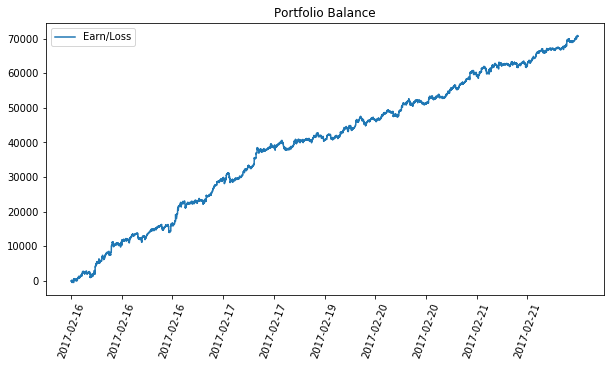

In [13]:
# -- Stochastic Oscilator Graph -- #
plt.figure(4, figsize=(10, 5))
plt.title('Portfolio Balance')
plt.plot(df3_Acc['Earn/Loss'], label='Earn/Loss')
plt.xticks(rotation=70)
plt.xticks(np.arange(0, len(df1_Prices), len(df1_Prices)/n_tick), d)
plt.legend()
plt.show()


In [15]:
Cap_In = 100000 
print('The final percentage of yield is:')
yield_ = df2_Ops[df2_Ops['Status'] == 'Closed']['Margin']
yield_ = sum(pd.to_numeric(yield_))
print(str(yield_*Units/Cap_In*100) + '%')


The final percentage of yield is:
70.70016999999886%


## Conclusion: /
The technical analysis had a 70.7% yield over 2 years. It is much more than any guburnamental of free risk rate available in the market. Of course there are no transaction fees in this model. For this badge, in the period of 16/02/2017-05/03/2019 the model prensented with the technical analysis indicators and parameters worked well. Technical Analysis i s a great tool to make investments with trading algorithms as well as manual trading. 


## Indicators Functions from Technical Analysis Library(ta) -- #
/
# These functions will add a column to the Historical DataFrame with the value of the indicator.
# T.A. library "ta" has implemented 32 indicators:
* Volume
  * Accumulation/Distribution Index (ADI)
  * On-Balance Volume (OBV)
  * On-Balance Volume mean (OBV mean)
  * Chaikin Money Flow (CMF)
  * Force Index (FI)
  * Ease of Movement (EoM, EMV)
  * Volume-price Trend (VPT)
  * Negative Volume Index (NVI)
* Volatility
  * Average True Range (ATR)
  * Bollinger Bands (BB)
  * Keltner Channel (KC)
  * Donchian Channel (DC)
* Trend
  * Moving Average Convergence Divergence (MACD)
  * Average Directional Movement Index (ADX)
  * Vortex Indicator (VI)
  * Trix (TRIX)
  * Mass Index (MI)
  * Commodity Channel Index (CCI)
  * Detrended Price Oscillator (DPO)
  * KST Oscillator (KST)
  * Ichimoku Kinkō Hyō (Ichimoku)
* Momentum
  * Money Flow Index (MFI)
  * Relative Strength Index (RSI)
  * True strength index (TSI)
  * Ultimate Oscillator (UO)
  * Stochastic Oscillator (SR)
  * Williams %R (WR)
  * Awesome Oscillator (AO)
* Others
  * Daily Return (DR)
  * Daily Log Return (DLR)
  * Cumulative Return (CR)
    

## Notas
* Paso 1: Data Frame (df1_precios) descargando todos los precios, segun fechas y granularidad, Fecha, Apertura, Maximo, Minimo, Cierre.

* Paso 2: Data Frame (df2_operaciones)
  * Fecha, Folio (1 a n), Operacion (1 = compra, -1 = venta), Unidades (0 a n),
  * Margen (0 a n), Comentario ("razon con base al indicador")
  * Precio_apertura, Precio_cierre

* Paso 3: Data Frame Cuenta (df3_cuenta)
  * Fecha, Capital (Efectivo $), Flotante ($),
  * Balance (Capital+Flotante), Rend_Balance_acm, Comentario ("Se abrio operacion: compra/venta", "Se cerro operacion: Con perdia de: / Con ganancia de: ", 

* Paso 4: Generar un vector de fechas, de F1 hasta F2
  * par0_cap = 100000   # Capital a utilizar $100,000 Usd
  * par1_mar = 1000000  # Unidades por operacion maximo 1'000,000

* Criterios para trading:
  * Para cerrar una operacion: 1) TP o SL, 2) Regla con indicador
  * indice = [1, 2, 3, 4, 5]
  * columnas = ['A','B', 'C', 'D']
  * df = pd.DataFrame(index=indice, columns=columnas)
  * df = df.fillna(0) # -- llenar todas las celdas con 0s